In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
% cd /content/drive/MyDrive/Pytorch/Project/Celebrity_classification

/content/drive/MyDrive/py-master/DataScience/CelebrityFaceRecognition/server


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pywt
import json

import os
import shutil

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Dropout,BatchNormalization
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
detect = cv2.CascadeClassifier("haarcascade/haarcascade_frontalface_default.xml")
eye_detect = cv2.CascadeClassifier("haarcascade/haarcascade_eye.xml")

In [5]:
destination = "./images_dataset/croped_images/"

#instructor

In [ ]:
celebrity_file_name = {}
for i in os.scandir(destination):
    images_path = []
    for j in os.scandir(destination+"/"+i.name):
        images_path.append(j.path)
    celebrity_file_name[i.name] = images_path

In [ ]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [ ]:
X = []
y = []
y_dict = {}
label = 0
for person_name,person_images in celebrity_file_name.items():
    y_dict[person_name] = label
    for path in person_images:
        image = cv2.imread(path)
        scale_image = cv2.resize(image,(32,32))
        img_har = w2d(image,"db1",level=5)
        scale_ima_har = cv2.resize(img_har, (32,32))
        combine_img = np.vstack((scale_image.reshape(32*32*3,1),scale_ima_har.reshape(32*32,1)))
        X.append(combine_img)
        y.append(y_dict[person_name])
    label += 1
X = np.array(X).reshape(len(X),4096).astype(float)

In [ ]:
with open("label_name.json","w") as f:
    json.dump(y_dict, f)

In [ ]:
y = np.array(y)
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=.20)

#main

In [ ]:
img_gen = ImageDataGenerator(rotation_range=20,horizontal_flip=True,validation_split=.20)

In [ ]:
train_gen = img_gen.flow_from_directory(destination+"/train",target_size=(150,150),
                                        subset='training',batch_size=16,shuffle=True)
test_gen = img_gen.flow_from_directory(destination+"/train",target_size=(150,150),
                                       subset='validation',batch_size=8,shuffle=True)

Found 140 images belonging to 5 classes.
Found 34 images belonging to 5 classes.


In [ ]:
early_stop = EarlyStopping(monitor="val_loss",patience=5,verbose=1)

In [ ]:
with tf.device("/gpu:0"):
  model = Sequential()
  pretrain = ResNet152(include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(150,150,3),
    pooling='avg',
    classes=5,)

  for layer in pretrain.layers:
    layer.trainable = False
  model.add(pretrain)
  model.add(Flatten())

  model.add(Dense(500,activation="relu"))
  model.add(Dropout(.2))

  model.add(Dense(200,activation="relu"))
  model.add(Dropout(.2))

  model.add(Dense(50,activation="relu"))
  model.add(Dropout(.2))

  model.add(Dense(20,activation="relu"))
  model.add(Dense(5,activation="softmax"))

  model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
model.summary()

In [ ]:
with tf.device("/gpu:0"):
  model.fit_generator(train_gen,epochs=60,verbose=1,validation_data=test_gen,callbacks=[early_stop])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/60
9/9 [==============================] - 24s 771ms/step - loss: 1.8115 - accuracy: 0.2857 - val_loss: 1.1957 - val_accuracy: 0.4118
Epoch 2/60
9/9 [==============================] - 3s 322ms/step - loss: 1.3685 - accuracy: 0.4429 - val_loss: 0.7936 - val_accuracy: 0.7059
Epoch 3/60
9/9 [==============================] - 3s 311ms/step - loss: 1.0629 - accuracy: 0.6143 - val_loss: 0.5553 - val_accuracy: 0.8235
Epoch 4/60
9/9 [==============================] - 3s 314ms/step - loss: 0.7962 - accuracy: 0.6929 - val_loss: 0.5843 - val_accuracy: 0.7647
Epoch 5/60
9/9 [==============================] - 3s 312ms/step - loss: 0.8689 - accuracy: 0.6643 - val_loss: 0.4770 - val_accuracy: 0.8235
Epoch 6/60
9/9 [==============================] - 3s 320ms/step - loss: 0.6098 - accuracy: 0.7786 - val_loss: 0.4264 - val_accuracy: 0.8529
Epoch 7/60
9/9 [==============================] - 3s 314ms/step - loss: 0.5488 - accuracy: 0.8143 - val_loss: 0.4374 - val_accuracy: 0.7941
Epoch 8/60
9/9 [===

In [ ]:
import pandas as pd

frame = pd.DataFrame(model.history.history)

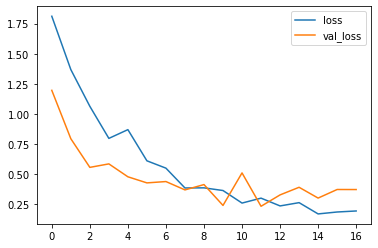

In [ ]:
frame[["loss","val_loss"]].plot()

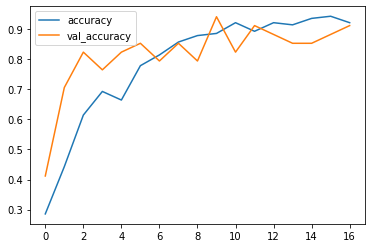

In [ ]:
frame[["accuracy","val_accuracy"]].plot()

In [14]:
def get_face(path):
    crop_faces = []
    image = cv2.imread(path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detect.detectMultiScale(image)
    for x1,y1,w,h in faces:
        face_crop = image[y1:y1+h, x1:x1+w]
        face_crop_gray = gray[y1:y1+h, x1:x1+w]
        eyes = eye_detect.detectMultiScale(face_crop)
        if len(eyes) >= 2:
            crop_faces.append(cv2.resize(face_crop,(150,150)))
    if len(crop_faces) > 0:
      return crop_faces 

In [ ]:
model.save("model.h5")

In [ ]:
model = load_model("model.h5")

In [ ]:
def predict(path):
  image = plt.imread(path)
  player = get_face(path)
  player_reshape = player.reshape(1,150,150,3)
  predict = model.predict(player_reshape)
  print(predict)
  print(predict.argmax())
  print(name[str(predict.argmax())])
  return plt.imshow(image)

In [ ]:
model.evaluate_generator(test_gen)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[0.29563799500465393, 0.9411764740943909]

In [ ]:
with open("label_name.json") as f:
  name = json.load(f)

In [ ]:
name

{'0': 'lionel_messi',
 '1': 'maria_sharapova',
 '2': 'roger_federer',
 '3': 'serena_williams',
 '4': 'virat_kohli'}

[[2.8794354e-03 3.3340166e-05 9.9674618e-01 2.9993975e-05 3.1104992e-04]]
2
roger_federer


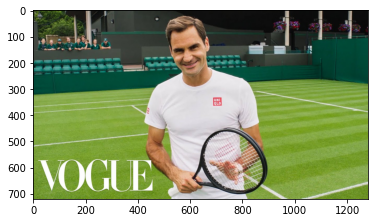

In [ ]:
predict("virat-kohli.jpg")

In [8]:
image = cv2.imread("virat-kohli.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = detect.detectMultiScale(image)

316 81 228 228
664 96 205 205
748 107 172 172


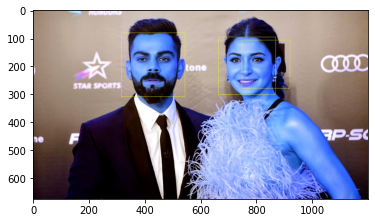

In [12]:
for x1,y1,w,h in faces:
  print(x1,y1,w,h)
  cv2.rectangle(image,(x1,y1),(x1+w,y1+h),(255,255,0),1)
plt.imshow(image)

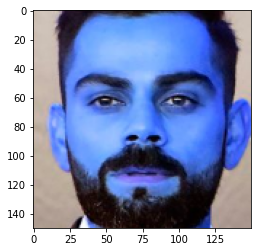

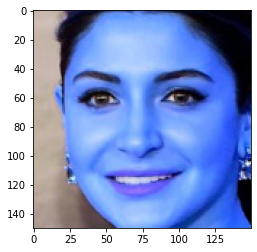

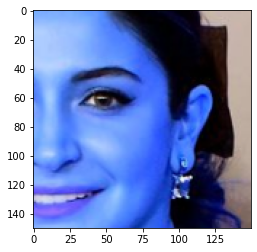

In [18]:
img = get_face("virat-kohli.jpg")
for i in img:
  plt.imshow(i)
  plt.show()

In [22]:
list(np.array([0.04, 0.01, 1.62, 0.3 , 8.03]))

[0.04, 0.01, 1.62, 0.3, 8.03]

In [27]:
with open("virat_base.txt","r") as f:
  base = f.read()

In [34]:
decoded = base.split(",")[1]

In [35]:
import base64
nparr = np.frombuffer(base64.b64decode(decoded), np.uint8)
img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

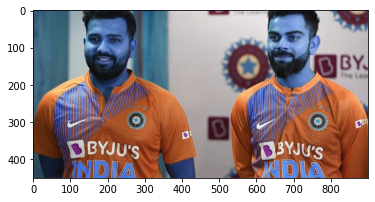

In [37]:
plt.imshow(img)

In [39]:
type(base)

str